# EDA: NFL Big Data Bowl 2026

Goal: understand the structure and scale of the data, then examine how much
player movement deviates from simple linear extrapolation. This feeds directly
into Approach 1 (baseline) and Approach 2 (per-role models).

In [1]:
import sys
sys.path.insert(0, '..')
sys.path.insert(0, '../scripts')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from load_data import load_input, load_output, load_paired

# Load weeks 1-3 for EDA (enough to be representative, fast enough to iterate)
inp, out = load_paired([1, 2, 3])
print(f'Input: {inp.shape[0]:,} rows | Output: {out.shape[0]:,} rows')

Input: 872,057 rows | Output: 100,348 rows


## 1. Scale and structure

In [2]:
plays = inp.groupby(['game_id', 'play_id']).ngroups
unique_players = inp['nfl_id'].nunique()
predicted_players = inp[inp['player_to_predict']]['nfl_id'].nunique()

print(f'Games: {inp["game_id"].nunique()}')
print(f'Plays: {plays}')
print(f'Unique players: {unique_players}')
print(f'Players with predictions to make: {predicted_players}')
print(f'\nPlayers per play (input):')
print(inp.groupby(['game_id','play_id'])['nfl_id'].nunique().describe())
print(f'\nOutput sequences per play:')
print(out.groupby(['game_id','play_id'])['nfl_id'].nunique().describe())

Games: 48
Plays: 2573
Unique players: 938
Players with predictions to make: 781

Players per play (input):
count    2573.000000
mean       12.289157
std         1.093752
min         6.000000
25%        12.000000
50%        13.000000
75%        13.000000
max        17.000000
Name: nfl_id, dtype: float64

Output sequences per play:
count    2573.000000
mean        3.263117
std         1.285290
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max         9.000000
Name: nfl_id, dtype: float64


In [3]:
# Role breakdown
role_counts = inp.groupby('player_role')['nfl_id'].nunique().sort_values(ascending=False)
print('Unique players by role (across all plays):')
print(role_counts)
print()

# Rows (player-frames) by role
print('Input rows by role:')
print(inp['player_role'].value_counts())

Unique players by role (across all plays):
player_role
Defensive Coverage    505
Other Route Runner    388
Targeted Receiver     332
Passer                 43
Name: nfl_id, dtype: int64

Input rows by role:
player_role
Defensive Coverage    474294
Other Route Runner    256117
Targeted Receiver      70847
Passer                 70799
Name: count, dtype: int64


## 2. Output sequence lengths

How many frames do we need to predict per play? This determines how far
into the future we're forecasting.

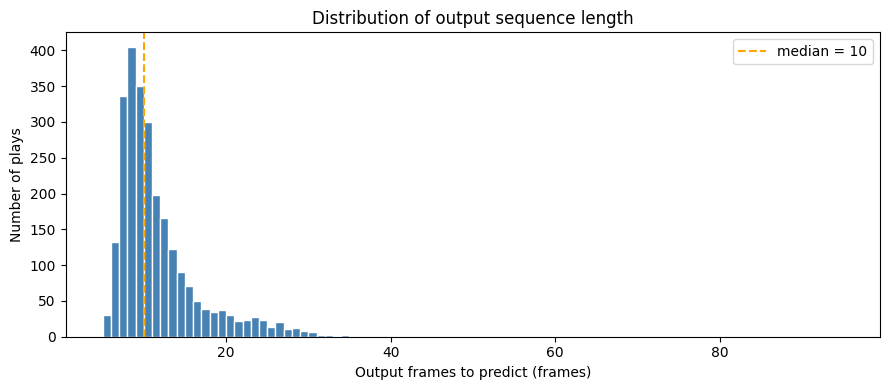

count    2573.000000
mean       11.171007
std         5.235168
min         5.000000
25%         8.000000
50%        10.000000
75%        13.000000
max        94.000000
Name: num_frames_output, dtype: float64

At 10 fps: median = 1.0s, max = 9.4s


In [4]:
# num_frames_output is the same for all players in a play
seq_lens = inp.groupby(['game_id','play_id'])['num_frames_output'].first()

fig, ax = plt.subplots(figsize=(9, 4))
ax.hist(seq_lens, bins=range(seq_lens.min(), seq_lens.max()+2), edgecolor='white', color='steelblue')
ax.set_xlabel('Output frames to predict (frames)')
ax.set_ylabel('Number of plays')
ax.set_title('Distribution of output sequence length')
ax.axvline(seq_lens.median(), color='orange', linestyle='--', label=f'median = {seq_lens.median():.0f}')
ax.legend()
plt.tight_layout()
plt.show()

print(seq_lens.describe())
print(f'\nAt 10 fps: median = {seq_lens.median()/10:.1f}s, max = {seq_lens.max()/10:.1f}s')

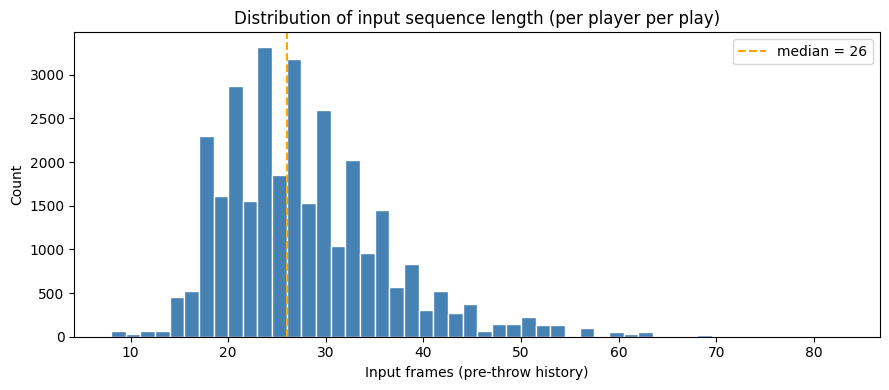

count    31620.000000
mean        27.579285
std          8.619063
min          8.000000
25%         21.000000
50%         26.000000
75%         32.000000
max         83.000000
Name: frame_id, dtype: float64


In [5]:
# Input sequence lengths (how much history do we have?)
inp_lens = inp.groupby(['game_id','play_id','nfl_id'])['frame_id'].count()

fig, ax = plt.subplots(figsize=(9, 4))
ax.hist(inp_lens, bins=50, edgecolor='white', color='steelblue')
ax.set_xlabel('Input frames (pre-throw history)')
ax.set_ylabel('Count')
ax.set_title('Distribution of input sequence length (per player per play)')
ax.axvline(inp_lens.median(), color='orange', linestyle='--', label=f'median = {inp_lens.median():.0f}')
ax.legend()
plt.tight_layout()
plt.show()

print(inp_lens.describe())

## 3. How good is straight-line extrapolation?

Take the last input frame for each player (position, speed, direction at throw time).
Project forward in a straight line. Compare against actual output positions.
This is Approach 1 — we're measuring its error here before we even build it formally.

In [6]:
# Get the last input frame per player per play
last_frame = (
    inp.sort_values('frame_id')
    .groupby(['game_id', 'play_id', 'nfl_id'])
    .last()
    .reset_index()
)

# Convert speed (yards/sec) and direction (degrees) to x/y velocity components.
# dir=0 is north (increasing y? or decreasing y?). In NFL tracking, dir=0 is
# typically toward the top of the field. We'll check with the data.
# Standard: dir is measured clockwise from north.
# vx = s * sin(dir), vy = s * cos(dir) — but we need to verify sign conventions.

dir_rad = np.radians(last_frame['dir'])
last_frame['vx'] = last_frame['s'] * np.sin(dir_rad)
last_frame['vy'] = last_frame['s'] * np.cos(dir_rad)

print('Velocity components computed.')
print(last_frame[['x','y','s','dir','vx','vy']].describe())

Velocity components computed.
                  x             y             s           dir            vx  \
count  31620.000000  31620.000000  31620.000000  31620.000000  31620.000000   
mean      64.225028     26.688553      4.305813    120.169490      2.489211   
std       23.830853     11.142446      2.125518     83.748389      2.533405   
min        3.170000      0.800000      0.000000      0.000000     -6.987997   
25%       45.270000     17.660000      2.690000     62.087500      0.598910   
50%       61.440000     26.670000      4.280000    104.235000      2.303371   
75%       81.720000     35.730000      5.960000    157.842500      4.181115   
max      119.860000     52.840000     10.080000    359.990000     10.073295   

                 vy  
count  31620.000000  
mean      -0.044249  
std        3.231404  
min       -9.726074  
25%       -2.222829  
50%       -0.041547  
75%        2.139142  
max        9.755913  


In [7]:
# Merge last_frame with output to compute linear prediction error
# Output frame_id=1 is the first frame after the throw
# At 10 fps, each frame is 0.1 seconds

out_merged = out.merge(
    last_frame[['game_id','play_id','nfl_id','x','y','vx','vy','num_frames_output','player_role']],
    on=['game_id','play_id','nfl_id'],
    suffixes=('_actual', '_throw')
)

# Time in seconds since throw
out_merged['t'] = out_merged['frame_id'] * 0.1

# Linear prediction: position = throw_position + velocity * t
out_merged['x_pred'] = out_merged['x_throw'] + out_merged['vx'] * out_merged['t']
out_merged['y_pred'] = out_merged['y_throw'] + out_merged['vy'] * out_merged['t']

# Per-frame error
out_merged['err_x'] = out_merged['x_pred'] - out_merged['x_actual']
out_merged['err_y'] = out_merged['y_pred'] - out_merged['y_actual']
out_merged['err_dist'] = np.sqrt(out_merged['err_x']**2 + out_merged['err_y']**2)

# RMSE overall
rmse_overall = np.sqrt((out_merged['err_x']**2 + out_merged['err_y']**2).mean())
print(f'Linear extrapolation RMSE (overall): {rmse_overall:.3f} yards')
print(f'\nPer-component RMSE:')
print(f'  x: {np.sqrt((out_merged["err_x"]**2).mean()):.3f}')
print(f'  y: {np.sqrt((out_merged["err_y"]**2).mean()):.3f}')

Linear extrapolation RMSE (overall): 2.871 yards

Per-component RMSE:
  x: 1.973
  y: 2.085


In [8]:
# RMSE by player role — this is the key split for Approach 2
rmse_by_role = (
    out_merged.groupby('player_role')
    .apply(lambda g: np.sqrt((g['err_x']**2 + g['err_y']**2).mean()))
    .sort_values(ascending=False)
)
print('Linear extrapolation RMSE by player role:')
print(rmse_by_role)

# Row counts per role (to weight the above)
print('\nOutput frames by role:')
print(out_merged['player_role'].value_counts())

Linear extrapolation RMSE by player role:
player_role
Defensive Coverage    3.000648
Targeted Receiver     2.519618
dtype: float64

Output frames by role:
player_role
Defensive Coverage    71605
Targeted Receiver     28743
Name: count, dtype: int64


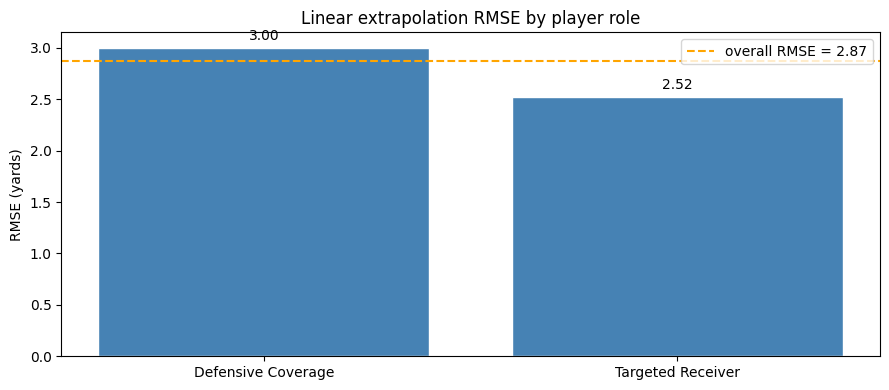

In [9]:
# RMSE by role, as a bar chart
fig, ax = plt.subplots(figsize=(9, 4))
roles = rmse_by_role.index.tolist()
vals = rmse_by_role.values
bars = ax.bar(roles, vals, color='steelblue', edgecolor='white')
ax.axhline(rmse_overall, color='orange', linestyle='--', label=f'overall RMSE = {rmse_overall:.2f}')
ax.set_ylabel('RMSE (yards)')
ax.set_title('Linear extrapolation RMSE by player role')
ax.legend()
for bar, val in zip(bars, vals):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, f'{val:.2f}', ha='center', va='bottom')
plt.tight_layout()
plt.show()

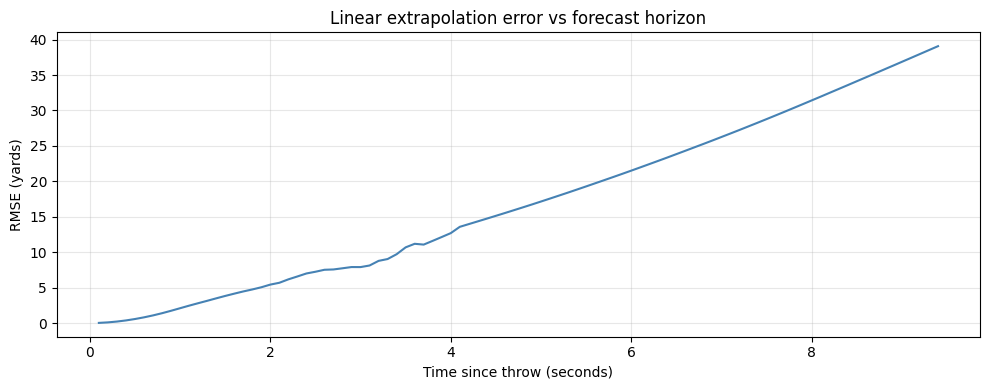

In [10]:
# RMSE vs time since throw — does error grow with forecast horizon?
rmse_by_frame = (
    out_merged.groupby('frame_id')
    .apply(lambda g: np.sqrt((g['err_x']**2 + g['err_y']**2).mean()))
)

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(rmse_by_frame.index * 0.1, rmse_by_frame.values, color='steelblue')
ax.set_xlabel('Time since throw (seconds)')
ax.set_ylabel('RMSE (yards)')
ax.set_title('Linear extrapolation error vs forecast horizon')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

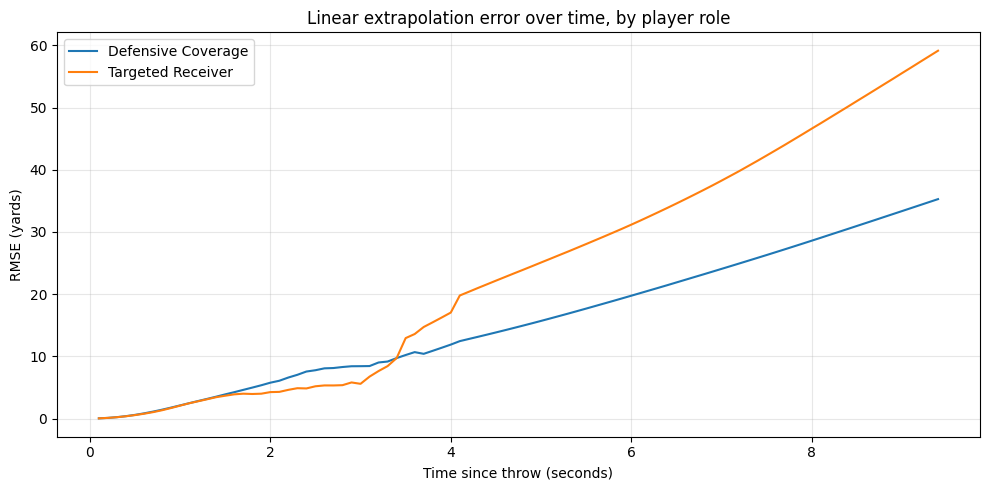

In [11]:
# Same plot but split by role — where does the gap between roles widen?
fig, ax = plt.subplots(figsize=(10, 5))
for role in out_merged['player_role'].unique():
    subset = out_merged[out_merged['player_role'] == role]
    rmse_t = (
        subset.groupby('frame_id')
        .apply(lambda g: np.sqrt((g['err_x']**2 + g['err_y']**2).mean()))
    )
    ax.plot(rmse_t.index * 0.1, rmse_t.values, label=role)

ax.set_xlabel('Time since throw (seconds)')
ax.set_ylabel('RMSE (yards)')
ax.set_title('Linear extrapolation error over time, by player role')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 4. Relationship between player and ball landing location

For the targeted receiver especially, the ball landing location should strongly
predict where they end up. Let's look at that.

In [12]:
# For targeted receivers: where do they end up vs where the ball lands?
tr = out_merged[out_merged['player_role'] == 'Targeted Receiver'].copy()

# Get their final position (last output frame)
tr_final = tr.sort_values('frame_id').groupby(['game_id','play_id','nfl_id']).last().reset_index()

# ball_land is in last_frame (from input)
ball = last_frame[['game_id','play_id','ball_land_x','ball_land_y']].drop_duplicates()
tr_final = tr_final.merge(ball, on=['game_id','play_id'])

tr_final['dist_to_ball'] = np.sqrt(
    (tr_final['x_actual'] - tr_final['ball_land_x'])**2 +
    (tr_final['y_actual'] - tr_final['ball_land_y'])**2
)

print('Targeted receiver final position vs ball landing spot:')
print(f'  Median distance: {tr_final["dist_to_ball"].median():.2f} yards')
print(f'  Mean distance:   {tr_final["dist_to_ball"].mean():.2f} yards')
print(f'  90th percentile: {tr_final["dist_to_ball"].quantile(0.9):.2f} yards')
print(f'  Max:             {tr_final["dist_to_ball"].max():.2f} yards')

Targeted receiver final position vs ball landing spot:
  Median distance: 1.27 yards
  Mean distance:   1.60 yards
  90th percentile: 2.93 yards
  Max:             21.77 yards


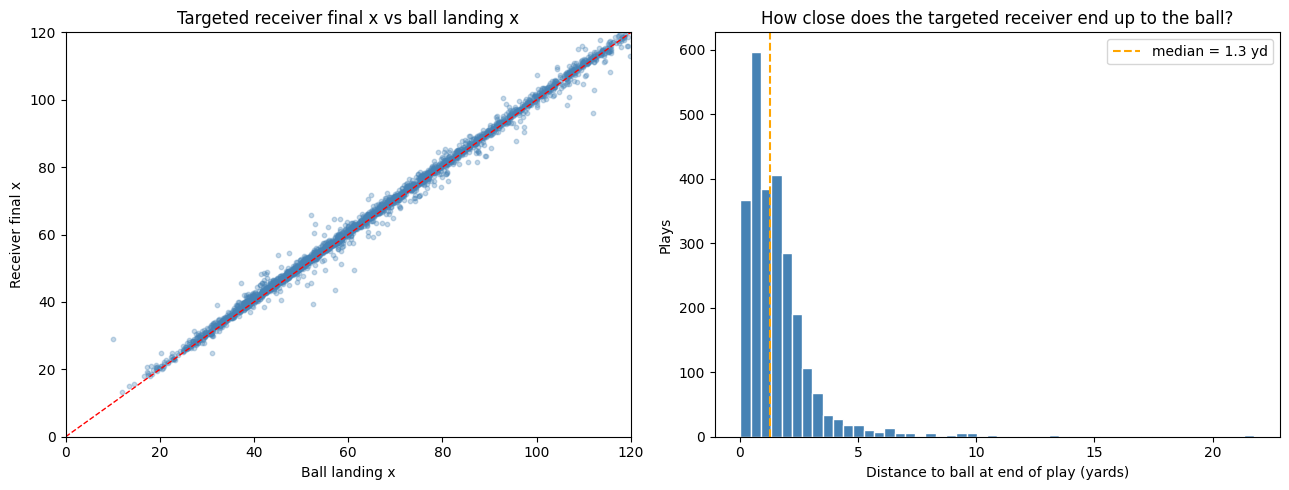

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# Scatter: final receiver position vs ball landing
ax = axes[0]
ax.scatter(tr_final['ball_land_x'], tr_final['x_actual'], alpha=0.3, s=10, color='steelblue')
lim = [0, 120]
ax.plot(lim, lim, 'r--', linewidth=1)
ax.set_xlabel('Ball landing x')
ax.set_ylabel('Receiver final x')
ax.set_title('Targeted receiver final x vs ball landing x')
ax.set_xlim(lim)
ax.set_ylim(lim)

# Histogram of distance to ball at end
ax = axes[1]
ax.hist(tr_final['dist_to_ball'], bins=50, color='steelblue', edgecolor='white')
ax.axvline(tr_final['dist_to_ball'].median(), color='orange', linestyle='--',
           label=f'median = {tr_final["dist_to_ball"].median():.1f} yd')
ax.set_xlabel('Distance to ball at end of play (yards)')
ax.set_ylabel('Plays')
ax.set_title('How close does the targeted receiver end up to the ball?')
ax.legend()

plt.tight_layout()
plt.show()

## Summary

Key findings to feed into Approaches 1 and 2:
- Linear extrapolation baseline RMSE: see cell above
- Error grows with forecast horizon (as expected)
- Player roles have very different error profiles — targeted receivers deviate most from straight lines
- Targeted receivers end up near the ball landing spot — ball_land_x/y is a strong signal for them
- Defenders and other route runners are harder: they react to the receiver, not directly to the ball